# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Autocodificadores" data-toc-modified-id="Autocodificadores-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Autocodificadores</a></div><div class="lev2 toc-item"><a href="#Redução-de-dimensionalidade" data-toc-modified-id="Redução-de-dimensionalidade-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Redução de dimensionalidade</a></div><div class="lev2 toc-item"><a href="#Treinando-uma-camada-de-cada-vez" data-toc-modified-id="Treinando-uma-camada-de-cada-vez-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Treinando uma camada de cada vez</a></div><div class="lev2 toc-item"><a href="#Rede-com-camadas-pré-treinadas" data-toc-modified-id="Rede-com-camadas-pré-treinadas-13"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Rede com camadas pré-treinadas</a></div>

# Autocodificadores

fonte: https://blog.keras.io/building-autoencoders-in-keras.html

Este notebook apresenta os autocodificadores.

In [1]:
import os
import keras.backend as K
K.set_image_data_format("channels_first")

Using TensorFlow backend.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plot

import sys
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist

sys.path.append('../src/')
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

In [10]:
(x_train, x_test), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(-1, 28*28).astype('float32') / 255.
x_test = x_test.reshape(-1, 28*28).astype('float32') / 255.
print(x_train.shape, x_test.shape)


(60000, 784) (10000, 784)


<table align='left'>
<tr><td> <img src="../figures/autoencoder_1.png"> </td></tr>
</table>



## Redução de dimensionalidade

In [14]:
model_name = 'autoencoder_dense_2'

if not os.path.isfile(model_name + '.model'):
    input_img = Input(shape=(28*28,))

    x = Dense(512, activation='relu')(input_img)
    x = Dense(128, activation='relu')(x)
    encoded = Dense(2, activation='linear', name='encoded')(x)

    # at this point the representation is 2-dimensional

    x = Dense(128, activation='relu')(encoded)
    x = Dense(512, activation='relu')(x)
    decoded = Dense(28*28, activation='linear')(x)
    
    autoencoder = Model(input_img, decoded)
    autoencoder.compile(optimizer='adam', loss='mse')
    histo = TrainingPlotter(n=1, filepath=model_name, patience=10)

else:
    autoencoder, histo = load_model_and_history(model_name)
    
encoder = Model(autoencoder.input, autoencoder.layers_by_depth[3][0].output)
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
encoded (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_3 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_4 (Dense)              (None, 512)               66048     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               402192    
Total para

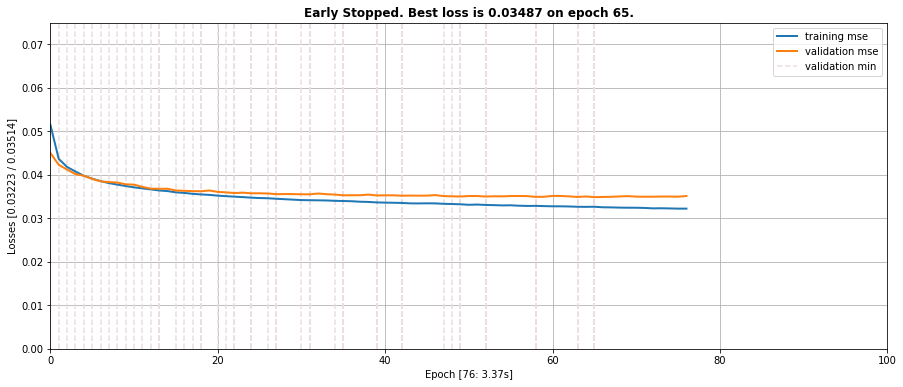

In [5]:
nb_epochs = 100
tr_epochs = histo.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.ylim(0.0, 0.075)
plot.xlim(0, nb_epochs)
plot.grid(True)

try:
    autoencoder.fit(x_train, x_train,
                    epochs=nb_epochs - tr_epochs,
                    batch_size=128,
                    shuffle=True,
                    verbose=0,
                    validation_data=(x_test, x_test),
                    callbacks=[histo])
    
except KeyboardInterrupt:
    pass

In [6]:
autoencoder, histo = load_model_and_history(model_name)

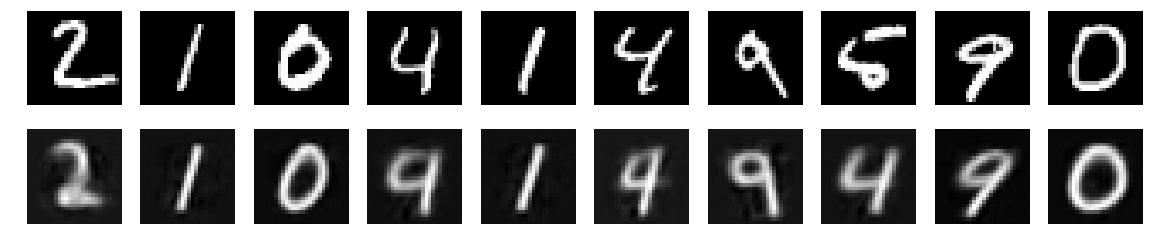

In [7]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plot.figure(figsize=(20, 4))
plot.gray()
for i in range(1,n+1):
    # display original
    ax = plot.subplot(2, n, i)
    plot.imshow(x_test[i].reshape(28, 28))
    plot.axis('off')

    # display reconstruction
    ax = plot.subplot(2, n, i + n)
    plot.imshow(decoded_imgs[i].reshape(28, 28))
    plot.axis('off')
plot.show()


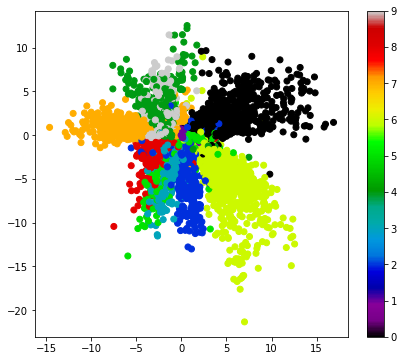

In [28]:
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=100)
plot.figure(figsize=(7, 6))
plot.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap=plot.cm.spectral)
plot.colorbar();


## Treinando uma camada de cada vez

<table align='left'>
<tr><td> <img src="../figures/autoencoder_2.png"> </td></tr>
</table>


## Rede com camadas pré-treinadas

<table align='left'>
<tr><td> <img src="../figures/autoencoder_3.png"> </td></tr>
</table>
